In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path
import shutil
def analyze_dice_distribution(json_file_path, csv_file_path):
    # Reading the JSON file
    with open(json_file_path, "r") as file:
        json_data = json.load(file)

    # Reading the CSV file
    csv_data = pd.read_csv(csv_file_path)

    # Extracting dice values and matching with the CSV data
    dice_values_with_tumors = []
    dice_values_without_tumors = []

    for entry in json_data.values():
        subject_name = entry["Name"]
        dice_value = entry["dice"]

        match = csv_data[csv_data["Subject"] == subject_name]
        if not match.empty:
            if match["Tumors_Present"].values[0] == 1:
                dice_values_with_tumors.append(dice_value)
            else:
                dice_values_without_tumors.append(dice_value)

    # Function to plot distribution
    def plot_distribution(dice_values, title, ax):
        mean_dice = np.mean(dice_values)
        std_dice = np.std(dice_values)

        ax.hist(dice_values, bins=10, alpha=0.7, color="blue", edgecolor="black")

        ax.axvline(
            mean_dice, color="red", linestyle="dashed", linewidth=1, label="Mean"
        )
        ax.axvline(
            mean_dice + std_dice,
            color="green",
            linestyle="dashed",
            linewidth=1,
            label="+1 Std Dev",
        )
        ax.axvline(mean_dice - std_dice, color="green", linestyle="dashed", linewidth=1)
        ax.axvline(
            mean_dice + 2 * std_dice,
            color="orange",
            linestyle="dashed",
            linewidth=1,
            label="+2 Std Dev",
        )
        ax.axvline(
            mean_dice - 2 * std_dice, color="orange", linestyle="dashed", linewidth=1
        )

        ax.set_xlabel("Dice Coefficient")
        ax.set_ylabel("Frequency")
        ax.set_title(title + f"({mean_dice:.2f}+/-{std_dice:.2f})")
        ax.legend()

    # Creating the plots
    fig, axs = plt.subplots(2, 1, figsize=(5, 6))

    plot_distribution(
        dice_values_with_tumors,
        f"Distribution of Dice Coefficients (Tumors Present)(N={len(dice_values_with_tumors)})",
        axs[0],
    )
    plot_distribution(
        dice_values_without_tumors,
        f"Distribution of Dice Coefficients (No Tumors)(N={len(dice_values_without_tumors)})",
        axs[1],
    )
    print(np.unique(dice_values_without_tumors, return_counts=True))

    # Display the plots
    plt.tight_layout()
    plt.show()


def print_paths(
    sorted_data: list,
    cval: str,
    img_dir: Path,
    lbl_dir: Path,
    pred_dir: Path,
    copy_file=True,
):
    if copy_file:
        dest_dir = Path(f"filtered_files_{pred_dir.name}/{cval}")
        dest_dir.mkdir(exist_ok=True, parents=True)

    for fname, dice in sorted_data:
        if dice <= 0.5:
            img_path = img_dir / fname.replace(".nii.gz", "_0001.nii.gz")
            ct_path = img_dir / fname.replace(".nii.gz", "_0000.nii.gz")
            lbl_path = lbl_dir / fname
            pred_path = pred_dir / fname

            # Print the paths and information
            print(img_path)
            print(lbl_path)
            print(pred_path)
            print(f"Filename: {fname}, Dice: {dice:.4f}")
            print(100 * "*~")

            # Copy the files to the destination directory if copy_file is True
            if copy_file:
                shutil.copy(img_path, dest_dir)
                shutil.copy(lbl_path, dest_dir)
                shutil.copy(ct_path, dest_dir)
                shutil.copy(pred_path, dest_dir/ fname.replace(".nii.gz", f"_pred_{dice:.2f}.nii.gz"))


def filter_subjects(cval, json_path, img_dir, lbl_dir, pred_dir):
    with open(json_path, "r") as file:
        data = json.load(file)

    # Extract the names and dice values for the specified cval
    filtered_data = [
        (item["Name"], item["dice"]) for item in data.values() if item["cm_val"] == cval
    ]

    # Sort the data by dice value in ascending order
    sorted_data = sorted(filtered_data, key=lambda x: x[1])

    # Print the sorted filenames and their dice values
    print(f"List of subjects for {cval} (sorted by dice value):")
    print_paths(sorted_data, cval, img_dir, lbl_dir, pred_dir)
    return sorted_data


def print_cm(cm_val):
    # Count occurrences of each label
    counts = Counter(cm_val)

    # Extract counts for TN, FN, FP, and TP
    tn = counts['tn']
    fn = counts['fn']
    fp = counts['fp']
    tp = counts['tp']

    # Create the confusion matrix in the desired order
    confusion_matrix = [[tn, fn], 
                        [fp, tp]]

    # Print the confusion matrix
    for row in confusion_matrix:
        print(row)

def get_mean_cm(json_path):# Load the JSON file
    with open(json_path, "r") as file:
        data = json.load(file)
    # Extract the dice values
    dice_values = [item["dice"] for item in data.values()]

    cm_values = [item["cm_val"] for item in data.values()]

    # Calculate the mean dice
    mean_dice = sum(dice_values) / len(dice_values)
    print_cm(cm_values)
    # Print the mean dice
    print(f"Mean Dice coefficient: {mean_dice:.4f}")
    return mean_dice, cm_values
# # Example usage:
# json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset020_AutoPET2024_res_test.json"
# csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
# analyze_dice_distribution(json_file_path, csv_file_path)

In [2]:
# # Paths to the files
# json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/Dataset019_AutoPET2024_resXL_test.json"
# csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
# analyze_dice_distribution(json_file_path, csv_file_path)
# get_mean_cm(json_file_path)

(array([0, 1]), array([16, 39]))


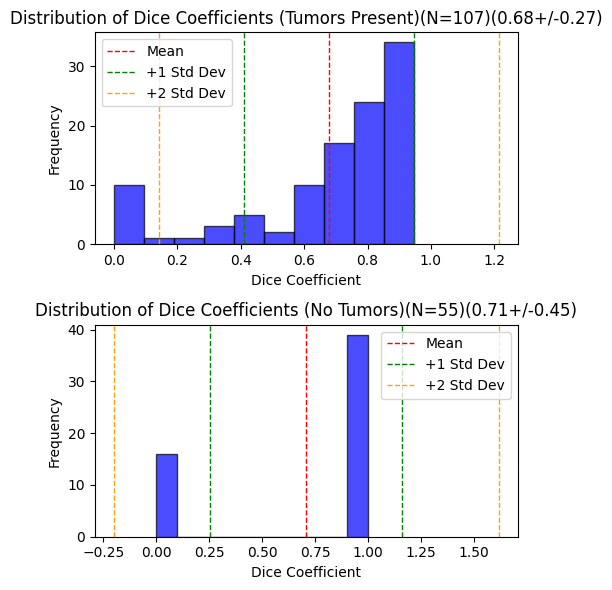

[39, 6]
[16, 101]
Mean Dice coefficient: 0.6880


In [3]:
# Paths to the files
json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/cl_prd.json"
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
analyze_dice_distribution(json_file_path, csv_file_path)
src_dir = Path(
    "/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/"
)
img_dir = src_dir / "imagesTs"
pred_dir = src_dir / "confidence_estimates_pred"
lbl_dir = src_dir / "labelsTs"
dice_mean, cm_val = get_mean_cm(json_file_path)
# fn_list = filter_subjects("fn", json_file_path, img_dir, lbl_dir, pred_dir)
# fp_list = filter_subjects("fp", json_file_path, img_dir, lbl_dir, pred_dir)
# tp_list = filter_subjects("tp", json_file_path, img_dir, lbl_dir, pred_dir)
# tn_list = filter_subjects("tn", json_file_path, img_dir, lbl_dir, pred_dir)

# print_paths(fn_list, img_dir, lbl_dir, pred_dir)

(array([0, 1]), array([15, 40]))


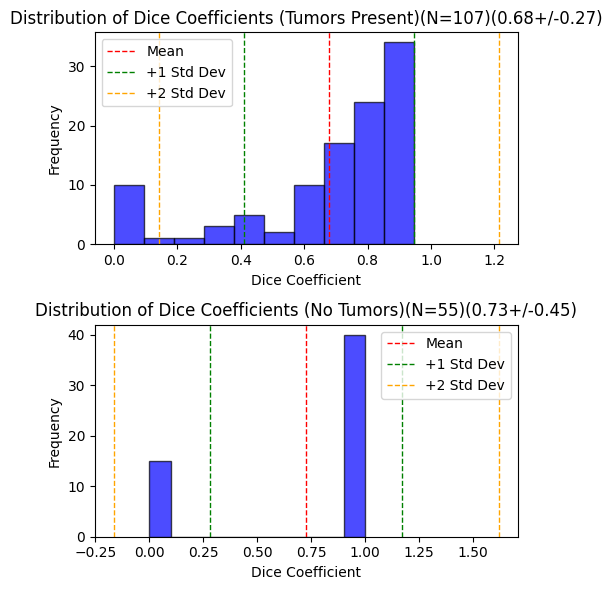

[40, 7]
[15, 100]
Mean Dice coefficient: 0.6941


In [5]:
# Paths to the files
json_file_path = (
    "/home/gmurugesan/projects/challenges/AutoPET2024/xl_only_cl_prd_zero_all_boundary.json"
)
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
analyze_dice_distribution(json_file_path, csv_file_path)
src_dir = Path(
    "/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/"
)
img_dir = src_dir / "imagesTs"
pred_dir = src_dir / "confidence_estimates_pred"
lbl_dir = src_dir / "labelsTs"
dice_mean, cm_val = get_mean_cm(json_file_path)
# fn_list = filter_subjects("fn", json_file_path, img_dir, lbl_dir, pred_dir)
# fp_list = filter_subjects("fp", json_file_path, img_dir, lbl_dir, pred_dir)
# tp_list = filter_subjects("tp", json_file_path, img_dir, lbl_dir, pred_dir)
# tn_list = filter_subjects("tn", json_file_path, img_dir, lbl_dir, pred_dir)

# print_paths(fn_list, img_dir, lbl_dir, pred_dir)

(array([0, 1]), array([15, 40]))


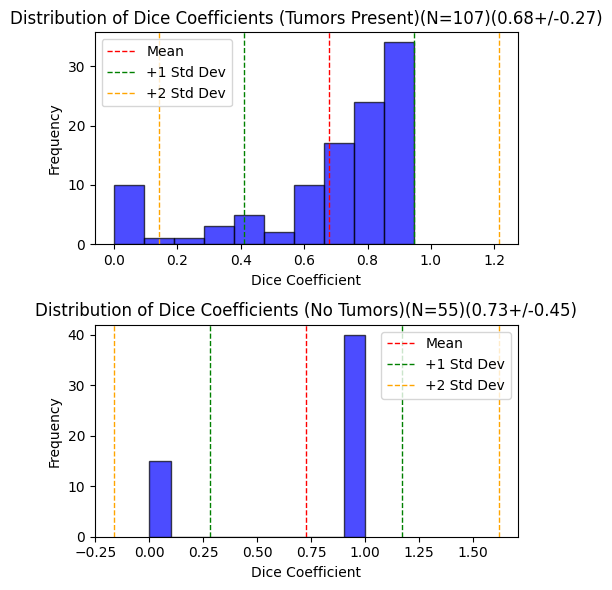

[40, 7]
[15, 100]
Mean Dice coefficient: 0.6941


In [6]:
# Paths to the files
json_file_path = (
    "/home/gmurugesan/projects/challenges/AutoPET2024/xl_no_cl_prd_zero_all_boundary.json"
)
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
analyze_dice_distribution(json_file_path, csv_file_path)
src_dir = Path(
    "/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/"
)
img_dir = src_dir / "imagesTs"
pred_dir = src_dir / "confidence_estimates_pred"
lbl_dir = src_dir / "labelsTs"
dice_mean, cm_val = get_mean_cm(json_file_path)
# fn_list = filter_subjects("fn", json_file_path, img_dir, lbl_dir, pred_dir)
# fp_list = filter_subjects("fp", json_file_path, img_dir, lbl_dir, pred_dir)
# tp_list = filter_subjects("tp", json_file_path, img_dir, lbl_dir, pred_dir)
# tn_list = filter_subjects("tn", json_file_path, img_dir, lbl_dir, pred_dir)

# print_paths(fn_list, img_dir, lbl_dir, pred_dir)

(array([0, 1]), array([15, 40]))


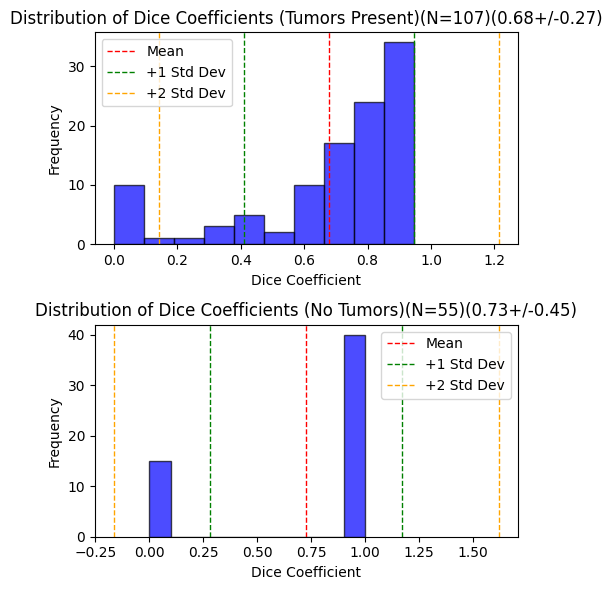

[40, 7]
[15, 100]
Mean Dice coefficient: 0.6941
List of subjects for fn (sorted by dice value):
/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/imagesTs/fdg_1b199d094d_03-16-2002-NA-PET-CT_Ganzkoerper__primaer_mit_KM-32644_0001.nii.gz
/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/labelsTs/fdg_1b199d094d_03-16-2002-NA-PET-CT_Ganzkoerper__primaer_mit_KM-32644.nii.gz
/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/confidence_estimates_pred/fdg_1b199d094d_03-16-2002-NA-PET-CT_Ganzkoerper__primaer_mit_KM-32644.nii.gz
Filename: fdg_1b199d094d_03-16-2002-NA-PET-CT_Ganzkoerper__primaer_mit_KM-32644.nii.gz, Dice: 0.0000
*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*

In [7]:
# Paths to the files
json_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/xl_only_cl_prd_zero_all_boundary.json"
csv_file_path = "/home/gmurugesan/projects/challenges/AutoPET2024/healthy_tumor_patients_report_Test.csv"
analyze_dice_distribution(json_file_path, csv_file_path)
src_dir = Path(
    "/mnt/nfs/slow_ai_team/organ_segmentation/nnunet_liverv0.0/nnUNet_raw_database/nnUNet_raw/nnUNet_raw_data/Dataset019_AutoPET2024/"
)
img_dir = src_dir / "imagesTs"
pred_dir = src_dir / "confidence_estimates_pred"
lbl_dir = src_dir / "labelsTs"
dice_mean, cm_val = get_mean_cm(json_file_path)
fn_list = filter_subjects("fn", json_file_path, img_dir, lbl_dir, pred_dir)
fp_list = filter_subjects("fp", json_file_path, img_dir, lbl_dir, pred_dir)
tp_list = filter_subjects("tp", json_file_path, img_dir, lbl_dir, pred_dir)
tn_list = filter_subjects("tn", json_file_path, img_dir, lbl_dir, pred_dir)

# print_paths(fn_list, img_dir, lbl_dir, pred_dir)